<a href="https://www.kaggle.com/code/rodasgoniche/text-classification-lstm-2?scriptVersionId=296505504" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import re
import nltk
import emoji
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [2]:
df = pd.read_csv('/kaggle/input/combined-data/Combined Data.csv')

In [3]:
lemmatizer = WordNetLemmatizer()

# keep clinically important stopwords
STOP_WORDS = set(stopwords.words('english')) - {
    'i', 'me', 'my', 'not', 'no', 'never'
}

CONTRACTIONS = {
    "i'm": "i am",
    "can't": "cannot",
    "don't": "do not"
}

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }.get(tag, wordnet.NOUN)


def preprocess_mental_health_text(text):
    # --- basic cleanup ---
    text = re.sub(r'http\S+|^\[deleted\]$|r/\w+|@\w+', '', str(text).lower())

    # --- emoji normalization ---
    text = emoji.demojize(text)
    text = text.replace(":", " ").replace("_", " ")

    # --- punctuation normalization ---
    text = re.sub(r'!+', ' ! ', text)
    text = text.replace('...', ' ... ')

    # --- contraction expansion ---
    for con, exp in CONTRACTIONS.items():
        text = text.replace(con, exp)

    # --- repeated character normalization ---
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # --- negation handling ---
    for neg in ["not", "no", "never"]:
        text = re.sub(rf'\b{neg}\s+(\w+)', rf'{neg}_\1', text)

    # --- tokenization + lemmatization ---
    tokens = []
    for word in word_tokenize(text):
        if word not in STOP_WORDS:
            lemma = lemmatizer.lemmatize(word, get_wordnet_pos(word))
            if len(lemma) > 1 or lemma == 'i':
                tokens.append(lemma)

    return " ".join(tokens)

df['clean_text'] = df['statement'].apply(preprocess_mental_health_text)

In [4]:
df[['statement', 'clean_text']].head(5)

,statement,clean_text
0,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confuse mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,i 've shift my focus something else i still wo...
4,"I'm restless and restless, it's been a month n...",i restless restless 's month boy mean


In [5]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df['clean_text']
y = df['status']  # change to the name of your label column

# First split: train vs temp (temp will be split into val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Test samples:", len(X_test))

Train samples: 37130
Validation samples: 7956
Test samples: 7957


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)

def get_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y
    )
    return dict(zip(classes, weights))

class_weights = get_class_weights(y_train_enc)
print(class_weights)
num_classes = len(np.unique(y_train_enc))


{np.int64(0): np.float64(1.9493883551215414), np.int64(1): np.float64(2.6337069087813876), np.int64(2): np.float64(0.491911871861793), np.int64(3): np.float64(0.463418287112154), np.int64(4): np.float64(6.307117377271955), np.int64(5): np.float64(2.839553380238605), np.int64(6): np.float64(0.7113163087415467)}


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

2026-02-08 08:27:30.815456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770539251.014681      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770539251.074530      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770539251.569581      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770539251.569643      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770539251.569646      17 computation_placer.cc:177] computation placer alr

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_random = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=100
    ),
    LSTM(32),
    Dense(num_classes, activation='softmax')
])

model_random.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_random = model_random.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20


2026-02-08 08:27:48.704773: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1161/1161 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.3409 - loss: 1.8626 - val_accuracy: 0.4082 - val_loss: 1.4853
Epoch 2/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - accuracy: 0.4702 - loss: 1.5055 - val_accuracy: 0.5554 - val_loss: 1.0960
Epoch 3/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - accuracy: 0.6189 - loss: 1.0036 - val_accuracy: 0.6527 - val_loss: 0.9140
Epoch 4/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - accuracy: 0.7119 - loss: 0.7401 - val_accuracy: 0.6515 - val_loss: 0.9138
Epoch 5/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - accuracy: 0.7699 - loss: 0.5451 - val_accuracy: 0.6893 - val_loss: 0.8307
Epoch 6/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.8130 - loss: 0.4203 - val_accuracy: 0.6948 - val_loss: 0.8462
Epoch 7/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - accuracy: 0.8467 - loss: 0.3292 - val_accuracy: 0.7107 - val_loss: 0.8145
Epoch 8/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - accuracy: 0.8765 - loss: 0.26

In [9]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(y_test_seq, maxlen=max_len)

y_test_enc = label_encoder.transform(y_test)
y_pred_probs = model_random.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Metrics
acc = accuracy_score(y_test_enc, y_pred)
f1  = f1_score(y_test_enc, y_pred, average='macro')

print("Accuracy:", acc)
print("Macro F1:", f1)
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Accuracy: 0.6703531481714214
Macro F1: 0.6068520202582225
                      precision    recall  f1-score   support

             Anxiety       0.69      0.66      0.68       584
             Bipolar       0.70      0.65      0.67       431
          Depression       0.69      0.49      0.57      2311
              Normal       0.84      0.86      0.85      2453
Personality disorder       0.60      0.39      0.47       180
              Stress       0.53      0.32      0.40       400
            Suicidal       0.50      0.78      0.61      1598

            accuracy                           0.67      7957
           macro avg       0.65      0.59      0.61      7957
        weighted avg       0.69      0.67      0.67      7957



In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

def evaluate_lstm_model(model, X_test_pad, y_test_enc, label_encoder, model_name="Model"):
    y_pred_probs = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test_enc, y_pred)
    f1  = f1_score(y_test_enc, y_pred, average='macro')

    print(f"\n===== {model_name} =====")
    print("Accuracy:", acc)
    print("Macro F1:", f1)
    print(classification_report(
        y_test_enc,
        y_pred,
        target_names=label_encoder.classes_
    ))

    return acc, f1, confusion_matrix(y_test_enc, y_pred)

In [11]:
acc_rand, f1_rand, cm_rand = evaluate_lstm_model(
    model_random,
    X_test_pad,
    y_test_enc,
    label_encoder,
    model_name="LSTM (Random Embedding)"
)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

===== LSTM (Random Embedding) =====
Accuracy: 0.6703531481714214
Macro F1: 0.6068520202582225
                      precision    recall  f1-score   support

             Anxiety       0.69      0.66      0.68       584
             Bipolar       0.70      0.65      0.67       431
          Depression       0.69      0.49      0.57      2311
              Normal       0.84      0.86      0.85      2453
Personality disorder       0.60      0.39      0.47       180
              Stress       0.53      0.32      0.40       400
            Suicidal       0.50      0.78      0.61      1598

            accuracy                           0.67      7957
           macro avg       0.65      0.59      0.61      7957
        weighted avg       0.69      0.67      0.67      7957



In [12]:
y_val_pred_probs = model_random.predict(X_val_pad)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


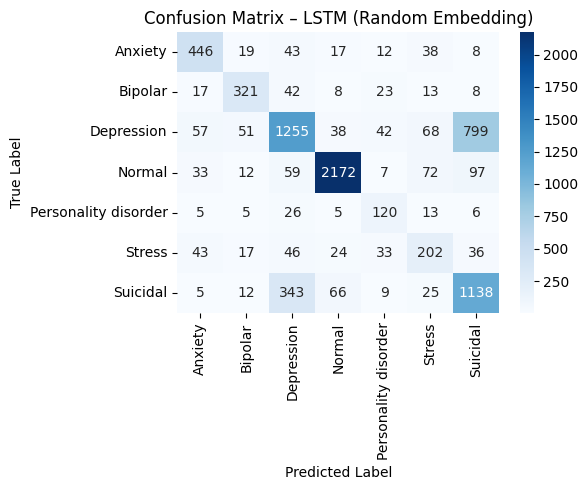

In [13]:
cm_random = confusion_matrix(y_val_enc, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_random,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – LSTM (Random Embedding)")
plt.tight_layout()
plt.show()

In [14]:
from gensim.models import Word2Vec

sentences = [text.split() for text in X_train]

w2v_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1  # sg=1 → Skip-gram, sg=0 → CBOW
)
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if idx < max_words and word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

/usr/local/lib/python3.12/dist-packages/google/cloud/aiplatform/models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


In [15]:
model_w2v = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False  
    ),
    LSTM(64),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_w2v.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_w2v = model_w2v.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.3598 - loss: 1.8118 - val_accuracy: 0.3355 - val_loss: 1.5209
Epoch 2/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - accuracy: 0.4815 - loss: 1.5796 - val_accuracy: 0.5181 - val_loss: 1.3002
Epoch 3/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - accuracy: 0.5259 - loss: 1.4194 - val_accuracy: 0.4844 - val_loss: 1.3594
Epoch 4/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - accuracy: 0.5080 - loss: 1.3949 - val_accuracy: 0.5439 - val_loss: 1.2271
Epoch 5/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - accuracy: 0.5754 - loss: 1.1767 - val_accuracy: 0.5283 - val_loss: 1.2699
Epoch 6/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - accuracy: 0.5550 - loss: 1.2554 - val_accuracy: 0.5928 - val_loss: 1.0900
Epoch 7/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.5823 - loss: 1.1515 - val_accuracy: 0.5851 - val_loss: 1.0978
Epoch 8/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.5872 -

In [16]:
acc_w2v, f1_w2v, cm_w2v = evaluate_lstm_model(
    model_w2v,
    X_test_pad,
    y_test_enc,
    label_encoder,
    model_name="LSTM (Word2Vec)"
)

249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step

===== LSTM (Word2Vec) =====
Accuracy: 0.6337815759708433
Macro F1: 0.5828843544614245
                      precision    recall  f1-score   support

             Anxiety       0.70      0.67      0.68       584
             Bipolar       0.63      0.71      0.67       431
          Depression       0.67      0.50      0.57      2311
              Normal       0.88      0.69      0.77      2453
Personality disorder       0.43      0.47      0.45       180
              Stress       0.60      0.25      0.35       400
            Suicidal       0.45      0.83      0.58      1598

            accuracy                           0.63      7957
           macro avg       0.62      0.59      0.58      7957
        weighted avg       0.68      0.63      0.64      7957



In [17]:
glove_path = "/kaggle/input/glove-6b-100d/glove.6B.100d.txt"
embeddings_index = {}

with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
embedding_matrix_glove = np.zeros((max_words, 100))

for word, idx in tokenizer.word_index.items():
    if idx < max_words and word in embeddings_index:
        embedding_matrix_glove[idx] = embeddings_index[word]

In [18]:
model_glove = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=100,
        weights=[embedding_matrix_glove],
        input_length=max_len,
        trainable=False
    ),
    LSTM(128),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_glove.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_glove = model_glove.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1161/1161 ━━━━━━━━━━━━━━━━━━━━ 109s 92ms/step - accuracy: 0.3454 - loss: 1.8055 - val_accuracy: 0.4333 - val_loss: 1.4398
Epoch 2/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 105s 91ms/step - accuracy: 0.4325 - loss: 1.5635 - val_accuracy: 0.5045 - val_loss: 1.2996
Epoch 3/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 105s 90ms/step - accuracy: 0.5326 - loss: 1.3134 - val_accuracy: 0.5977 - val_loss: 1.1007
Epoch 4/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 105s 90ms/step - accuracy: 0.6112 - loss: 1.1268 - val_accuracy: 0.6019 - val_loss: 1.1128
Epoch 5/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 108s 93ms/step - accuracy: 0.6393 - loss: 1.0364 - val_accuracy: 0.6780 - val_loss: 0.8531
Epoch 6/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 109s 94ms/step - accuracy: 0.6690 - loss: 0.9228 - val_accuracy: 0.6767 - val_loss: 0.9625
Epoch 7/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 113s 97ms/step - accuracy: 0.6844 - loss: 0.8609 - val_accuracy: 0.6961 - val_loss: 0.8436
Epoch 8/20
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 108s 93ms/step - accuracy: 0.6983 - lo

In [19]:
acc_glove, f1_glove, cm_glove = evaluate_lstm_model(
    model_glove,
    X_test_pad,
    y_test_enc,
    label_encoder,
    model_name="LSTM (GloVe)"
)

249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step

===== LSTM (GloVe) =====
Accuracy: 0.6160613296468518
Macro F1: 0.5296414692324204
                      precision    recall  f1-score   support

             Anxiety       0.67      0.59      0.63       584
             Bipolar       0.72      0.52      0.60       431
          Depression       0.74      0.31      0.44      2311
              Normal       0.73      0.91      0.81      2453
Personality disorder       0.26      0.42      0.32       180
              Stress       0.49      0.25      0.33       400
            Suicidal       0.46      0.74      0.57      1598

            accuracy                           0.62      7957
           macro avg       0.58      0.54      0.53      7957
        weighted avg       0.65      0.62      0.60      7957



In [20]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["LSTM (Random)", "LSTM (Word2Vec)", "LSTM (GloVe)"],
    "Accuracy": [acc_rand, acc_w2v, acc_glove],
    "Macro F1": [f1_rand, f1_w2v, f1_glove]
})

results_df


,Model,Accuracy,Macro F1
0,LSTM (Random),0.670353,0.606852
1,LSTM (Word2Vec),0.633782,0.582884
2,LSTM (GloVe),0.616061,0.529641


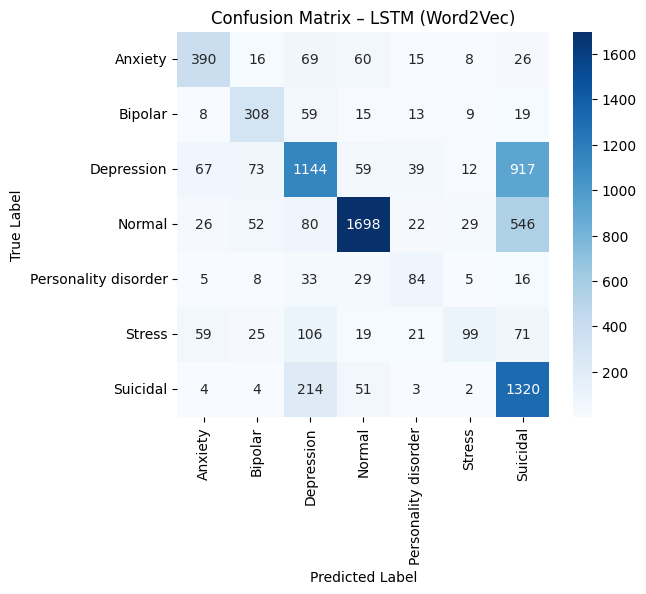

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

best_cm = cm_w2v  # or cm_glove if that performs better
best_model_name = "LSTM (Word2Vec)"

plt.figure(figsize=(6, 5))
sns.heatmap(
    best_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()


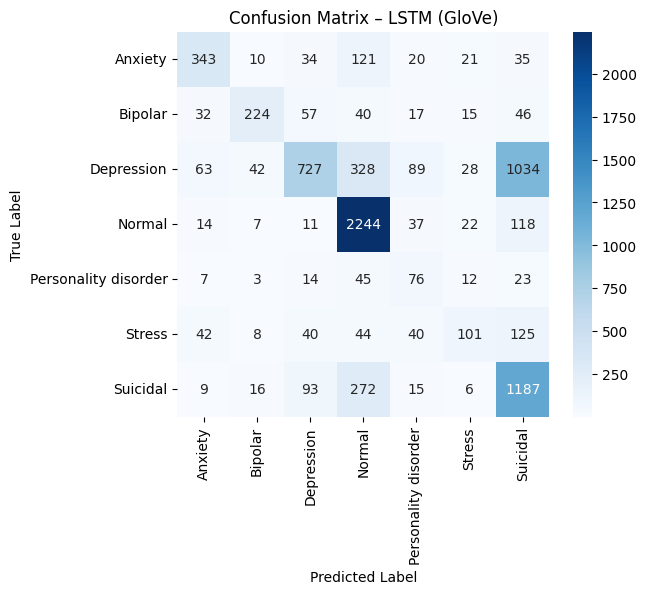

In [22]:
cm_glove = cm_glove
model_name = "LSTM (GloVe)"

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_glove,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix – {model_name}")
plt.show()


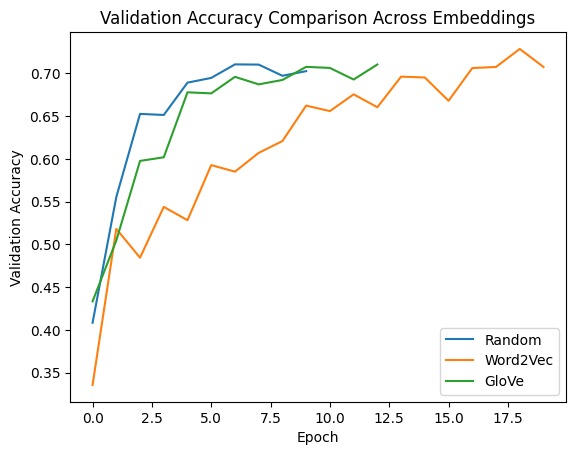

In [23]:
plt.figure()
plt.plot(history_random.history['val_accuracy'], label='Random')
plt.plot(history_w2v.history['val_accuracy'], label='Word2Vec')
plt.plot(history_glove.history['val_accuracy'], label='GloVe')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison Across Embeddings')
plt.legend()
plt.show()

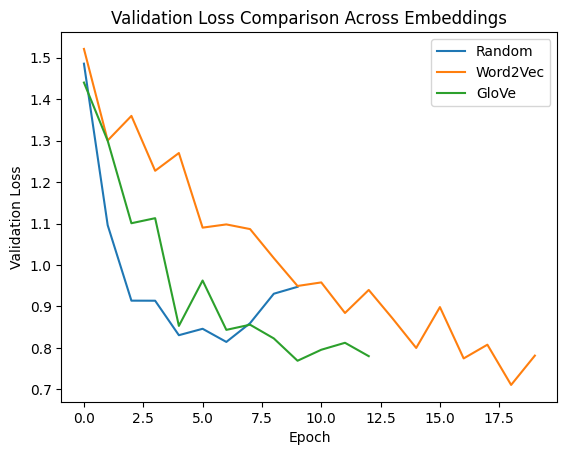

In [24]:
plt.figure()
plt.plot(history_random.history['val_loss'], label='Random')
plt.plot(history_w2v.history['val_loss'], label='Word2Vec')
plt.plot(history_glove.history['val_loss'], label='GloVe')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison Across Embeddings')
plt.legend()
plt.show()